In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def get_data(json_filename, incident_number):

    df_categorised = pd.read_json(json_filename)
    df_uncategorised = pd.read_json('data/uncategorised.json')

    # Get status of incident
    status = df_categorised['status']
    status = status[incident_number]

    # Get detailed info
    accel_df = df_categorised['detail']
    detail_dict = accel_df[incident_number]

    # Less detailed data
    gps_df = df_categorised['journey']
    journey_dict = gps_df[incident_number]

    # Zoomed out data, has long term speed and accelerometer data
    zoomed_out_df = pd.DataFrame.from_dict(journey_dict)

    # Zoomed in data, use to get the speed in smaller interval
    zoomed_in_df = pd.DataFrame.from_dict(detail_dict)

    # Extract the higher resolution accelerometer data for the crash
    forces = zoomed_in_df['forces']
    zoomed_in_tilts = []
    for second in forces:
        force_1 = pd.DataFrame.from_dict(second)
        zoomed_in_tilts.append(force_1)

    zoomed_in_tilts = pd.concat(zoomed_in_tilts)
    zoomed_in_tilts = zoomed_in_tilts.rename(columns={'index':'timeoffset'})

    linspace_1 = np.linspace(-6, 2.875, 72)
    zoomed_in_tilts['timeoffset'] = linspace_1

    # Changed zoomed_in_df to include t=0 and the other variables
    zoomed_in_df = zoomed_out_df[zoomed_out_df['event'] == 'CDistance']
    alert_row = zoomed_out_df[zoomed_out_df['event'] == 'Alert']
    zoomed_in_df = zoomed_in_df.append(alert_row)
    zoomed_in_df = zoomed_in_df.sort_index()
    

    return [zoomed_in_df, zoomed_out_df, zoomed_in_tilts, status]


# Data Format
On calling get_data it returns a list of 4 objects.

## Data[0]
This is the 'zoomed in' data from -6 seconds to +3 seconds. This includes speed and direction.
These data are also in Data[1].

## Data[1]
This is the 'zoomed out' data from the beginning of the recording, throught the incident to the end.
This includes events, speed, directions, grid references, tilts

## Data[2]
This is the 8hz, high resolution tilt data from -6 seconds to +2.875 seconds.


## Data[3]
This is the status of the incident, i.e. whether it is a confirmed crash of not.

Possible (Correct)


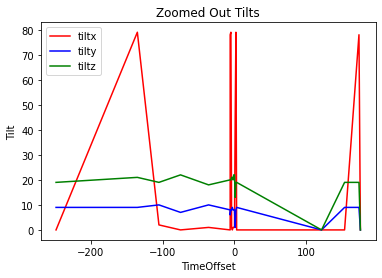

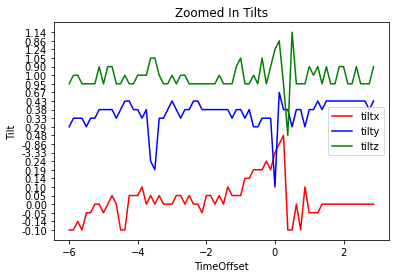

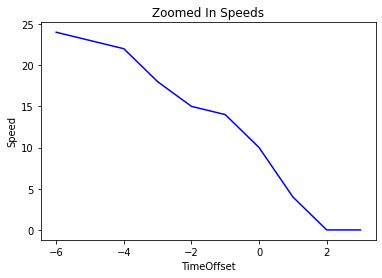

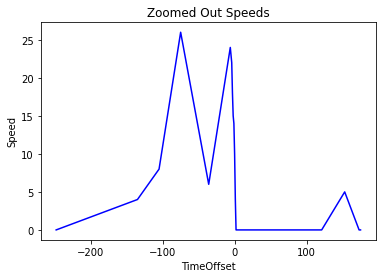

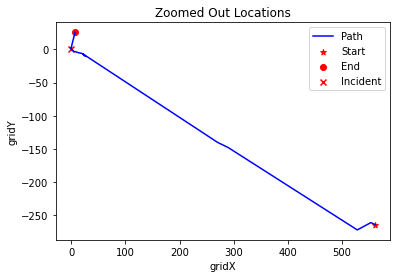

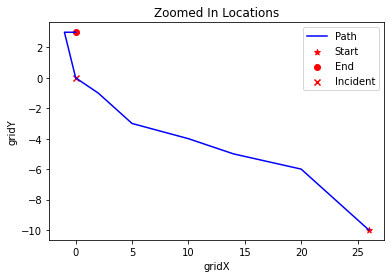

In [70]:
def plot_tilts(df, title):
    plt.plot(df['timeoffset'], df['tiltx'], label='tiltx', color='red')
    plt.plot(df['timeoffset'], df['tilty'], label='tilty', color='blue')
    plt.plot(df['timeoffset'], df['tiltz'], label='tiltz', color='green')
    plt.title(title), plt.xlabel('TimeOffset'), plt.ylabel('Tilt')
    plt.legend(loc='best')
    plt.show()

def plot_speeds(df, title):
    plt.plot(df['timeoffset'], df['speed'], label='Speed', color='blue')
    plt.title(title), plt.xlabel('TimeOffset'), plt.ylabel('Speed')
    plt.show()

def plot_grid(df, title):
    X = df['gridx']
    Y = df['gridy']
    plt.plot(X, Y, label='Path', color='blue')
    plt.scatter(X.iloc[0], Y.iloc[0], label='Start', marker='*', color='red')
    plt.scatter(X.iloc[-1], Y.iloc[-1], label='End', marker='o', color='red')
    plt.scatter(0,0, label='Incident', color='red', marker='x')
    plt.legend(loc='best')
    plt.title(title), plt.xlabel('gridX'), plt.ylabel('gridY')
    plt.show()

# Change the number of the second argument to get data for a different incident
data = get_data('data/categorised.json', 2)

zoomed_in_df = data[0]
zoomed_out_df = data[1]
zoomed_in_tilts = data[2]
status = data[3]

# Tells us if crash or not
print(status)

# Plotting
plot_tilts(data[1], 'Zoomed Out Tilts')
plot_tilts(data[2], 'Zoomed In Tilts')
plot_speeds(data[0], 'Zoomed In Speeds')
plot_speeds(data[1], 'Zoomed Out Speeds')
plot_grid(data[1], 'Zoomed Out Locations')
plot_grid(data[0], 'Zoomed In Locations')


In [4]:
# Read all the data and put it in one list
df_categorised = pd.read_json('data/categorised.json')
all_data = []
for i in range(len(df_categorised)):
    data = get_data('data/categorised.json', i)
    all_data.append(data)
for i in range(len(all_data)):
    # Changes labels to binary system
    if 'Correct' in all_data[i][3]:
        all_data[i][3] = 1
    else:
        all_data[i][3] = 0

In [5]:
def get_stats(X):
    # Function that gets the means and variances for the tilts of each axis for each crash
    all_means = []
    all_vars = []
    all_ranges = []
    
    for crash in X:

        crash_means = []
        crash_vars = []
        crash_ranges = []

        for axis in range(3):
            axis = crash[:,axis]
            axis = axis.astype(float)

            mean = np.mean(axis)
            var = np.var(axis)
            a_range = np.amax(axis) - np.amin(axis)

            crash_means.append(mean)
            crash_vars.append(var)
            crash_ranges.append(a_range)
            
        all_means.append(crash_means)
        all_vars.append(crash_vars)
        all_ranges.append(crash_ranges)

    all_crash_means = np.asarray(all_means)
    all_crash_vars = np.asarray(all_vars)
    all_crash_ranges = np.asarray(all_ranges)

    return all_crash_means, all_crash_vars, all_crash_ranges

C:\Users\chris\AppData\Local\Temp/ipykernel_2288/1056172774.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_data = np.array(all_data)


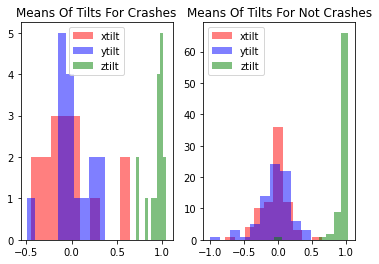

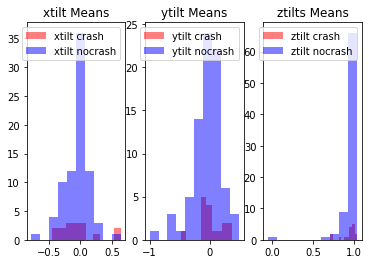

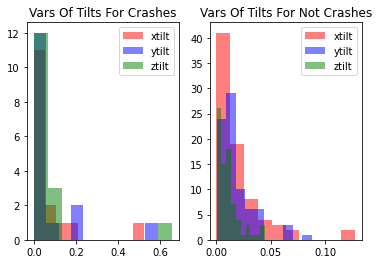

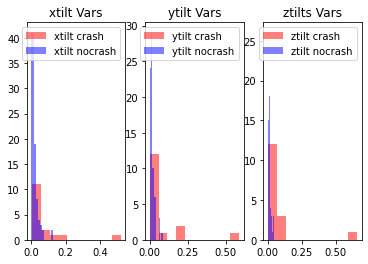

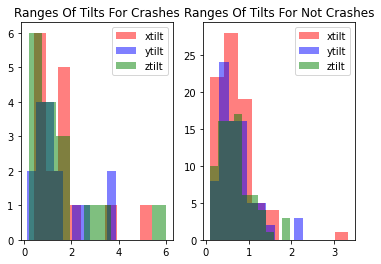

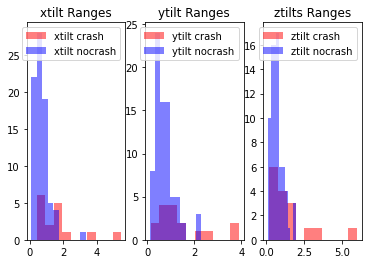

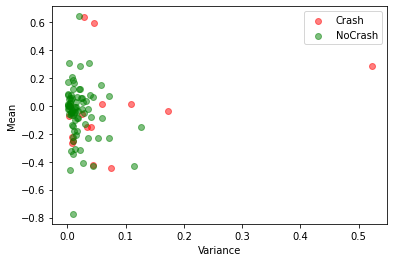

In [6]:
# Split the list up into labels and features
# These features are the 8hz tilt data
all_data = np.array(all_data)
y = all_data[:,3]
X = all_data[:,2]

X_new = []
for element in range(len(X)):
    df = X[element]
    array = df.iloc[:,1:].to_numpy()
    X_new.append(array)
# X is now a list of arrays containing the 8hz tilt data
X = np.asarray(X_new)

crash_ref = y.nonzero()
nocrash_ref = (y-1)*(-1)
nocrash_ref = nocrash_ref.nonzero()

X_crash = X[crash_ref]
X_nocrash = X[nocrash_ref]  

# Get the means for comparisons
crash_means, crash_vars, crash_ranges = get_stats(X_crash)
nocrash_means, nocrash_vars, nocrash_ranges = get_stats(X_nocrash)

def plot_stat_hist(stat1, stat2, stat_str):
    plt.subplot(1,2,1)
    plt.hist(stat1[:,0], color='red', label='xtilt', alpha=0.5)
    plt.hist(stat1[:,1], color='blue', label='ytilt', alpha=0.5)
    plt.hist(stat1[:,2], color='green',label='ztilt', alpha=0.5)
    plt.title(stat_str + ' Of Tilts For Crashes'), plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.hist(stat2[:,0], color='red', label='xtilt', alpha=0.5)
    plt.hist(stat2[:,1], color='blue', label='ytilt', alpha=0.5)
    plt.hist(stat2[:,2], color='green',label='ztilt', alpha=0.5)
    plt.title(stat_str + ' Of Tilts For Not Crashes'), plt.legend(loc='best')
    plt.show()

    plt.subplot(1,3,1)
    plt.hist(stat1[:,0], color='red', label='xtilt crash', alpha=0.5)
    plt.hist(stat2[:,0], color='blue', label='xtilt nocrash', alpha=0.5)
    plt.title('xtilt ' + stat_str ), plt.legend(loc='best')
    plt.subplot(1,3,2)
    plt.hist(stat1[:,1], color='red', label='ytilt crash', alpha=0.5)
    plt.hist(stat2[:,1], color='blue', label='ytilt nocrash', alpha=0.5)
    plt.title('ytilt ' + stat_str ), plt.legend(loc='best')
    plt.subplot(1,3,3)
    plt.hist(stat1[:,2], color='red', label='ztilt crash', alpha=0.5)
    plt.hist(stat2[:,2], color='blue', label='ztilt nocrash', alpha=0.5)
    plt.title('ztilts ' + stat_str ), plt.legend(loc='best')
    plt.show()

plot_stat_hist(crash_means, nocrash_means, 'Means')
plot_stat_hist(crash_vars, nocrash_vars, 'Vars')
plot_stat_hist(crash_ranges, nocrash_ranges, 'Ranges')

plt.scatter(crash_vars[:,0], crash_means[:,0], color='red', alpha=0.5, label='Crash')
plt.scatter(nocrash_vars[:,0], nocrash_means[:,0], color='green', alpha=0.5, label='NoCrash')
plt.legend(loc='best'), plt.xlabel('Variance'), plt.ylabel('Mean')
plt.show()


C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 32 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\chris\anaconda3\envs\MDMvenv\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 63 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


[[18  8]
 [ 4  2]]
Accuracy on test set: 62.5
[[38 15]
 [ 4  6]]
Accuracy on training set: 69.84126984126983


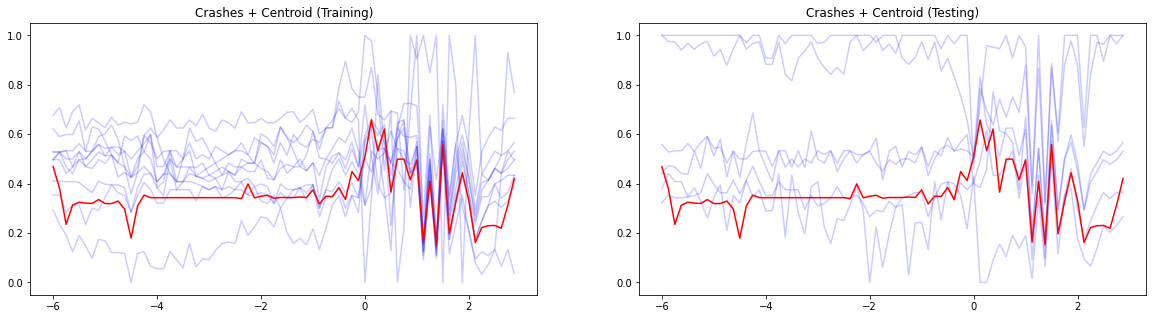

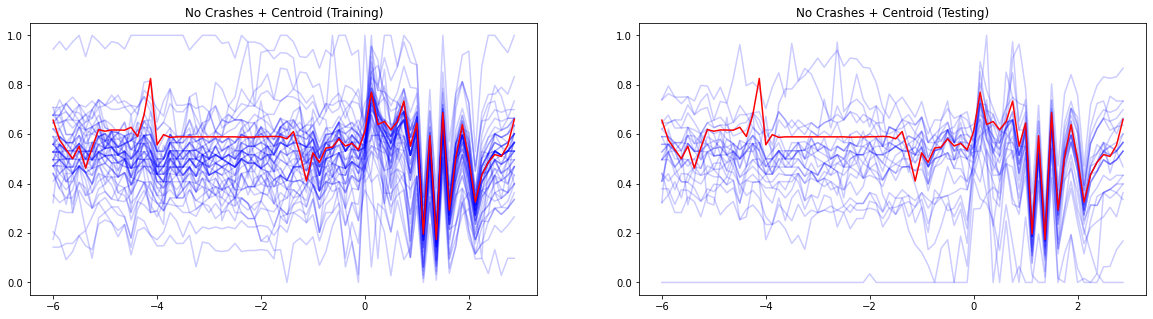

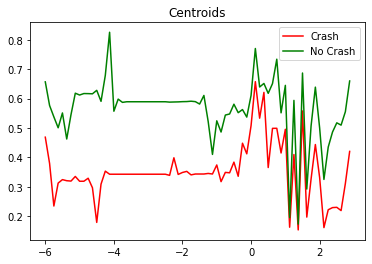

In [96]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Time series clustering
# Get x tilts as first test of clustering
X_xtilts=np.empty([72,len(X)])
for i in range(len(X)):
    X_xtilts[:,i] = X[i][:,0]

# normalise the data
for i in range(len(X_xtilts)):
    X_xtilts[i] = (X_xtilts[i]-X_xtilts[i].min())/(X_xtilts[i].max()-X_xtilts[i].min())

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(np.transpose(X_xtilts), y, test_size=0.33, random_state=42)

# Compute clusters
km = TimeSeriesKMeans(n_clusters=2, max_iter=5, metric="dtw", random_state=0).fit(X_train)

# Make predictions
test_predictions = km.predict(X_test)
train_predictions = km.predict(X_train)

# Print accuracies and confusion matrices
print(confusion_matrix(y_test.astype(int), test_predictions))
test_acc = accuracy_score(y_test.astype(int), test_predictions)
print('Accuracy on test set: '+ str(test_acc*100))
print(confusion_matrix(y_train.astype(int), train_predictions))
train_acc = accuracy_score(y_train.astype(int), train_predictions)
print('Accuracy on training set: '+ str(train_acc*100))

X_train_crash = X_train[y_train.nonzero()]
X_train_nocrash = X_train[((y_train-1)*-1).nonzero()]

X_test_crash = X_test[y_test.nonzero()]
X_test_nocrash = X_test[((y_test-1)*-1).nonzero()]

centroids = km.cluster_centers_
linspace_1 = np.linspace(-6, 2.875, 72)

# Crash data
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i in range(len(X_train_crash)):
    plt.plot(linspace_1, X_train_crash[i], color='blue', alpha=0.2)
plt.plot(linspace_1, centroids[1], color='red', label='Crash')
plt.title('Crashes + Centroid (Training)')
plt.subplot(1,2,2)
for i in range(len(X_test_crash)):
    plt.plot(linspace_1, X_test_crash[i], color='blue', alpha=0.2)
plt.plot(linspace_1, centroids[1], color='red', label='Crash')
plt.title('Crashes + Centroid (Testing)')
plt.show()

# No crash data
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i in range(len(X_train_nocrash)):
    plt.plot(linspace_1, X_train_nocrash[i], color='blue', alpha=0.2)
plt.plot(linspace_1, centroids[0], color='red', label='No Crash')
plt.title('No Crashes + Centroid (Training)')
plt.subplot(1,2,2)
for i in range(len(X_test_nocrash)):
    plt.plot(linspace_1, X_test_nocrash[i], color='blue', alpha=0.2)
plt.plot(linspace_1, centroids[0], color='red', label='Crash')
plt.title('No Crashes + Centroid (Testing)')
plt.show()

#Centroid Comparison
plt.plot(linspace_1, centroids[1], color='red', label='Crash')
plt.plot(linspace_1, centroids[0], color='green', label='No Crash')
plt.legend(loc='best'), plt.title('Centroids')
plt.show()

#[TP, FP]
#[FN, TN]

In [100]:
from sklearn.ensemble import RandomForestClassifier

# using random forest classifier
classifier = RandomForestClassifier(n_estimators=3)
classifier.fit(X_train.astype(float), y_train.astype(int))
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

print(accuracy_score(y_test.astype(int), y_pred_test))
print(confusion_matrix(y_test.astype(int), y_pred_test))

print(accuracy_score(y_train.astype(int), y_pred_train))
print(confusion_matrix(y_train.astype(int), y_pred_train))


0.8125
[[25  1]
 [ 5  1]]
0.873015873015873
[[51  2]
 [ 6  4]]
